In [1]:
#! pip install grad-cam timm

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
valid_img_path_1_0 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/436219-7159-48057-[1, 0, 0].png'
valid_img_path_1_1 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant/436219-7159-48057-[1, 0, 0].png'
valid_img_path_1_2 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect/436219-7159-48057-[1, 0, 0].png'

valid_img_path_2_0 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/436219-9328-53637-[1, 1, 0].png'
valid_img_path_2_1 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant/436219-9328-53637-[1, 1, 0].png'
valid_img_path_2_2 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect/436219-9328-53637-[1, 1, 0].png'

valid_img_path_3_0 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/1003370-5631-18822-[0, 1, 0].png'
valid_img_path_3_1 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant/1003370-5631-18822-[0, 1, 0].png'
valid_img_path_3_2 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect/1003370-5631-18822-[0, 1, 0].png'

valid_img_path_4_0 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/449636-23526-9666-[0, 0, 1].png'
valid_img_path_4_1 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant/449636-23526-9666-[0, 0, 1].png'
valid_img_path_4_2 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect/449636-23526-9666-[0, 0, 1].png'

In [5]:
valid_img_1_0 = cv2.resize(cv2.imread(valid_img_path_1_0), (224, 224))
valid_img_1_1 = cv2.resize(cv2.imread(valid_img_path_1_1), (224, 224))
valid_img_1_2 = cv2.resize(cv2.imread(valid_img_path_1_2), (224, 224))

valid_img_2_0 = cv2.resize(cv2.imread(valid_img_path_2_0), (224, 224))
valid_img_2_1 = cv2.resize(cv2.imread(valid_img_path_2_1), (224, 224))
valid_img_2_2 = cv2.resize(cv2.imread(valid_img_path_2_2), (224, 224))

valid_img_3_0 = cv2.resize(cv2.imread(valid_img_path_3_0), (224, 224))
valid_img_3_1 = cv2.resize(cv2.imread(valid_img_path_3_1), (224, 224))
valid_img_3_2 = cv2.resize(cv2.imread(valid_img_path_3_2), (224, 224))

valid_img_4_0 = cv2.resize(cv2.imread(valid_img_path_4_0), (224, 224))
valid_img_4_1 = cv2.resize(cv2.imread(valid_img_path_4_1), (224, 224))
valid_img_4_2 = cv2.resize(cv2.imread(valid_img_path_4_2), (224, 224))

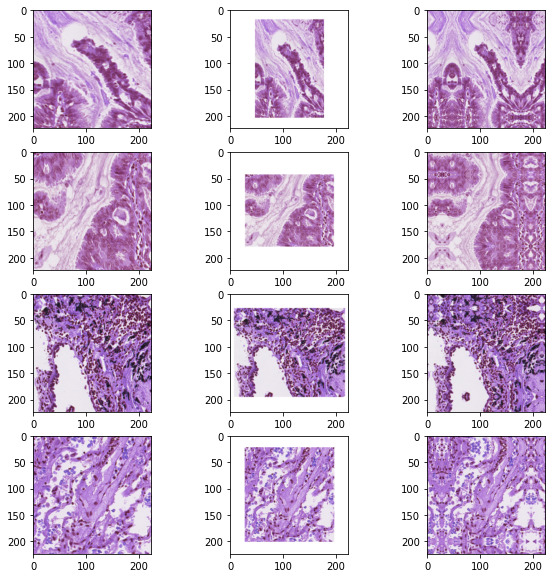

In [6]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(4, 3, 1)
plt.imshow(valid_img_1_0)
ax = fig.add_subplot(4, 3, 2)
plt.imshow(valid_img_1_1)
ax = fig.add_subplot(4, 3, 3)
plt.imshow(valid_img_1_2)

ax = fig.add_subplot(4, 3, 4)
plt.imshow(valid_img_2_0)
ax = fig.add_subplot(4, 3, 5)
plt.imshow(valid_img_2_1)
ax = fig.add_subplot(4, 3, 6)
plt.imshow(valid_img_2_2)

ax = fig.add_subplot(4, 3, 7)
plt.imshow(valid_img_3_0)
ax = fig.add_subplot(4, 3, 8)
plt.imshow(valid_img_3_1)
ax = fig.add_subplot(4, 3, 9)
plt.imshow(valid_img_3_2)

ax = fig.add_subplot(4, 3, 10)
plt.imshow(valid_img_4_0)
ax = fig.add_subplot(4, 3, 11)
plt.imshow(valid_img_4_1)
ax = fig.add_subplot(4, 3, 12)
plt.imshow(valid_img_4_2)

In [7]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [8]:
def reshape_transform(tensor, height=7, width=7):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [9]:
def mask_threshold(mask):
    v = np.concatenate(mask)
    t = v.mean()
    d = np.inf
    ds = 0.005
    while d > ds:
        g1 = v[v>t]
        g2 = v[v<=t]
        m1 = g1.mean()
        m2 = g2.mean()
        tp = (m1 + m2)/2
        d = np.abs(t - tp)
        t = tp
        #print(t)

    imt = mask > t

    return imt

In [10]:
model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for
                 x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if
                 '32' in x and 'deit' not in x]
model_weights.sort()
model_weights

['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/cutmix_model_vit_base_patch32_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/cutmix_model_vit_base_patch32_224_02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_1-01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_1-02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_1.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_2-01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_2.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_3-01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_3-02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_3.pth',
 '/home/zephyr/Desktop/Newcas

# Model 0: model_vit_32_224.pth

In [11]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch32_224', pretrained = False, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

model_vit_base_patch16_224.load_state_dict(torch.load(f=model_weights[6], map_location=device))

<All keys matched successfully>

In [15]:
%%capture
model_vit_base_patch16_224.eval()

In [16]:
target_layer = [model_vit_base_patch16_224.blocks[-1].norm1]
target_layer

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [17]:
valid_img_1_0_tensor = preprocess_image(valid_img_1_0,).to(device)
valid_img_1_1_tensor = preprocess_image(valid_img_1_1,).to(device)
valid_img_1_2_tensor = preprocess_image(valid_img_1_2,).to(device)

valid_img_2_0_tensor = preprocess_image(valid_img_2_0,).to(device)
valid_img_2_1_tensor = preprocess_image(valid_img_2_1,).to(device)
valid_img_2_2_tensor = preprocess_image(valid_img_2_2,).to(device)

valid_img_3_0_tensor = preprocess_image(valid_img_3_0,).to(device)
valid_img_3_1_tensor = preprocess_image(valid_img_3_1,).to(device)
valid_img_3_2_tensor = preprocess_image(valid_img_3_2,).to(device)

valid_img_4_0_tensor = preprocess_image(valid_img_4_0,).to(device)
valid_img_4_1_tensor = preprocess_image(valid_img_4_1,).to(device)
valid_img_4_2_tensor = preprocess_image(valid_img_4_2,).to(device)

## 01. GradCAM: img 0

In [18]:
cam = GradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

### Class 0: Tumor

In [19]:
valid_cam_0 = cam(input_tensor=valid_img_1_1_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_1_1_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_1_1_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

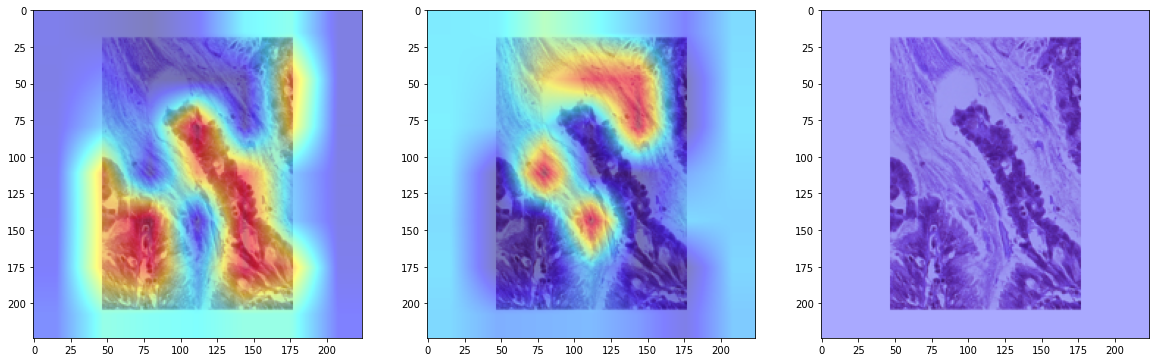

In [21]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img_1_1/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img_1_1/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img_1_1/255, valid_cam_2[0, :], use_rgb=True))

In [23]:
import PAR

In [24]:
par = PAR.PAR(num_iter=15, dilations=[1,2,4,8,12,24])

In [25]:
par.to(device)

PAR()

In [26]:
mask = par(valid_img_1_1_tensor, transforms.ToTensor()(valid_cam_0[0, :]).unsqueeze(0))

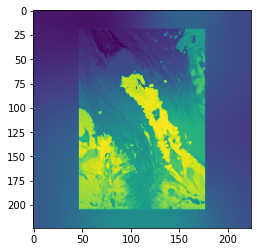

In [27]:
plt.imshow(mask.squeeze(0).squeeze(0))

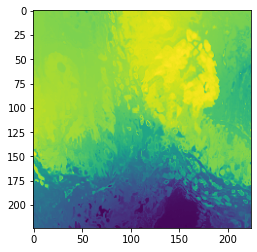

In [81]:
mask_2 = par(valid_img_2_tensor, mask)
plt.imshow(mask_2.squeeze(0).squeeze(0))

In [26]:
from sklearn.preprocessing import minmax_scale

In [27]:
t = mask.squeeze(0).squeeze(0).cpu().detach().numpy()
t.shape

(224, 224)

In [28]:
t.reshape(-1, 1).shape

(50176, 1)

In [29]:
t.shape

(224, 224)

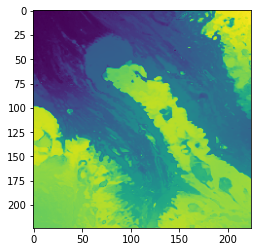

In [30]:
test = minmax_scale(t.reshape(-1, 1))
plt.imshow(test.reshape(224, 224))

In [39]:
np.unique(test)

array([0.0000000e+00, 1.4713005e-05, 1.0054873e-04, ..., 9.9790430e-01,
       9.9964559e-01, 1.0000000e+00], dtype=float32)

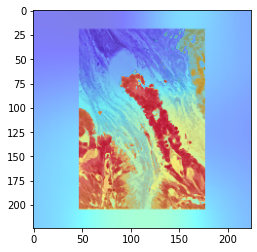

In [28]:
plt.imshow(show_cam_on_image(valid_img_1_1/255, mask.cpu().detach().numpy().squeeze(0).squeeze(0), use_rgb=True))

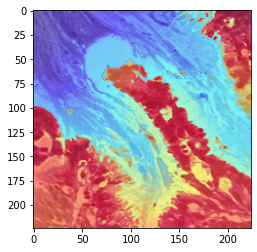

In [31]:
plt.imshow(show_cam_on_image(valid_img_1/255, test.reshape(224, 224), use_rgb=True))

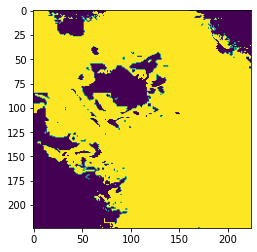

In [194]:
test_th = mask_threshold(test.reshape(224, 224))
plt.imshow(test_th)

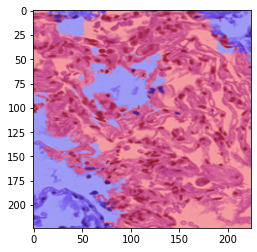

In [195]:
plt.imshow(show_cam_on_image(valid_img_4/255, test_th, use_rgb=True))

In [197]:
mask = par(valid_img_4_tensor, transforms.ToTensor()(test_th.astype(np.uint8)).unsqueeze(0))

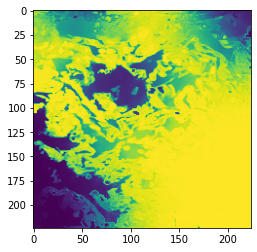

In [199]:
plt.imshow(mask.squeeze(0).squeeze(0))

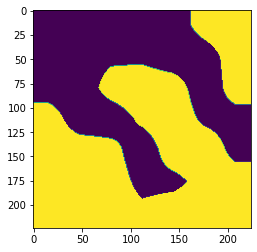

In [220]:
test_th = mask_threshold(valid_cam_0[0, :])
plt.imshow(test_th)

In [221]:
mask = par(valid_img_1_tensor, transforms.ToTensor()(test_th.astype(np.uint8)).unsqueeze(0))

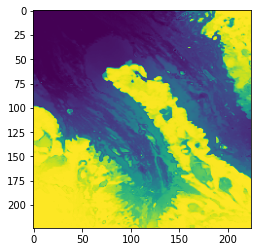

In [222]:
plt.imshow(mask.squeeze(0).squeeze(0))

In [205]:
np.percentile(mask.squeeze(0).squeeze(0), 5)

0.00030579492886317894

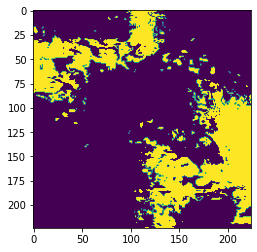

In [207]:
plt.imshow(mask.squeeze(0).squeeze(0)>np.percentile(mask.squeeze(0).squeeze(0), 75))

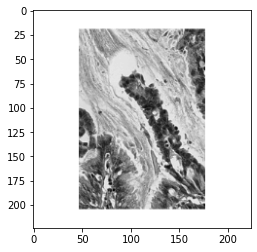

In [29]:
gray = cv2.cvtColor(valid_img_1_1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

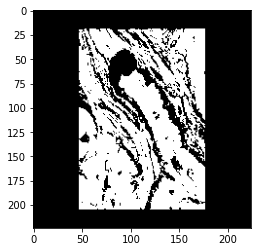

In [30]:
ret, thresh = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')

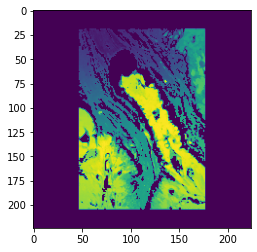

In [31]:
mask_bg_rem = mask.squeeze(0).squeeze(0)*thresh
plt.imshow(mask_bg_rem)

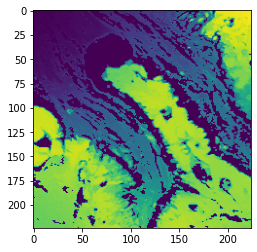

In [37]:
mask_bg_rem = test.reshape(224, 224)*thresh
plt.imshow(mask_bg_rem)

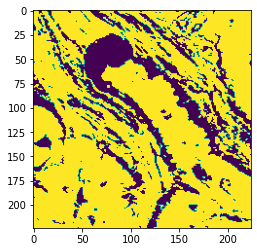

In [227]:
plt.imshow(mask_bg_rem>0)

In [38]:
type(mask_bg_rem)

numpy.ndarray

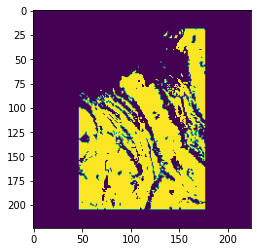

In [32]:
plt.imshow(mask_threshold(mask_bg_rem.cpu().detach().numpy()))

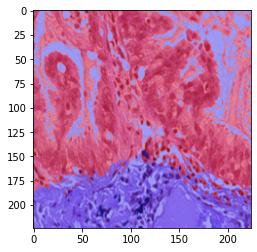

In [90]:
plt.imshow(show_cam_on_image(valid_img_2/255, mask_threshold(mask_bg_rem.cpu().detach().numpy()), use_rgb=True))

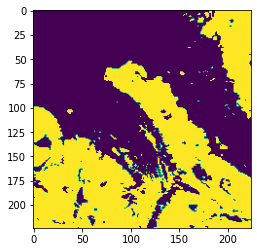

In [39]:
plt.imshow(mask_threshold(mask_bg_rem))

In [45]:
fin = mask_threshold(mask_bg_rem.cpu().detach().numpy())
np.unique(fin.astype(np.uint8))

array([0, 1], dtype=uint8)